In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage as nd

import download_drive_data as ddd
import serial_data_formatter as sdf

plt.style.use("bmh")

First we download the data from the google drive folder. The functions in ddd will ensure that the files are downloaded into a folder that will be ignored by git. It will also avoid overwriting data if it already exists locally.

In [2]:
try:
    ddd.download_folder("https://drive.google.com/drive/folders/1oLLm551wWjxr5CxWExkkv9oYtgzEdbtG?usp=sharing")
except FileExistsError as e:
    print(e)

Retrieving folder contents


Processing file 1HbvEq6IydnqTrHYC6SQaGRocMuryPynH 250908_1328_40mm_2mm.csv
Processing file 1ZshujyPyrQCPDEFawloDv4B9cCR1-MEA 250908_1335_40mm_1mm.csv
Processing file 1dh26Rq6ykelCkhEp7Tnx1uZBf4fe-3ps 250908_1403_40mm_3mm.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Download completed
Retrieving folder contents


Processing file 1HbvEq6IydnqTrHYC6SQaGRocMuryPynH 250908_1328_40mm_2mm.csv
Processing file 1ZshujyPyrQCPDEFawloDv4B9cCR1-MEA 250908_1335_40mm_1mm.csv
Processing file 1dh26Rq6ykelCkhEp7Tnx1uZBf4fe-3ps 250908_1403_40mm_3mm.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1HbvEq6IydnqTrHYC6SQaGRocMuryPynH
To: /home/alex/code/smart-suction/src/capcup/data/conductive_cup/250908_1328_40mm_2mm.csv
100%|██████████| 358k/358k [00:00<00:00, 20.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZshujyPyrQCPDEFawloDv4B9cCR1-MEA
To: /home/alex/code/smart-suction/src/capcup/data/conductive_cup/250908_1335_40mm_1mm.csv
100%|██████████| 354k/354k [00:00<00:00, 17.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dh26Rq6ykelCkhEp7Tnx1uZBf4fe-3ps
To: /home/alex/code/smart-suction/src/capcup/data/conductive_cup/250908_1403_40mm_3mm.csv
100%|██████████| 363k/363k [00:00<00:00, 10.1MB/s]
Download completed


The raw eval software output is then parsed to extract the capacitance data and some header information. The EvalBoardData object hold this information along with some stuff like generating timestamps.

The capacitance data is stored as raw ADC counts in decimal. 

In [2]:
data_directory = os.path.join(os.getcwd(), "data", "cup_electrode_GT")
trial_data = sdf.format_folder(data_directory)

# filter out any trials that you don't want to analyze
selected_trials = []
for trial in trial_data:
    selected_trials.append(trial)

In [3]:
def count2ff(counts):
    """24bit resolution measuring +/- 4.096 pF"""
    zero = 2**23
    return (counts - zero)*(4096/zero)


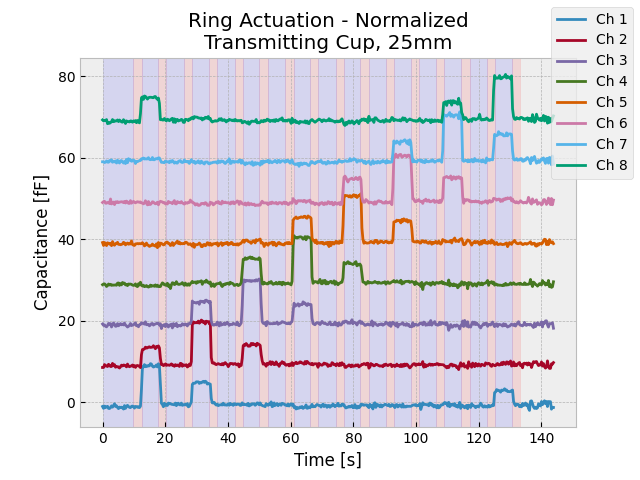

In [17]:
fig, ax = plt.subplots()
ax.plot(trial.time, trial.normalize(count2ff(trial.cap_counts)) + np.arange(8)*10)
for start, end in zip(trial.actuation_starts, trial.actuation_ends):
    ax.axvspan(trial.time[start], trial.time[end], color='red', alpha=0.1)
for start, end in zip(trial.segment_starts, trial.segment_ends):
    ax.axvspan(trial.time[start], trial.time[end], color='blue', alpha=0.1)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Capacitance [fF]")
ax.set_title("Ring Actuation - Normalized\nTransmitting Cup, 25mm")
fig.legend("Ch " + (1 + np.arange(8)).astype(str))


In [15]:
for trial in selected_trials:
    baselines = []
    steps = []
    std_data = np.empty((0, 8))

    for idx, (start, end) in enumerate(zip(trial.segment_starts, trial.segment_ends)):
        magnitude = np.mean(trial.cap_counts[start:end], axis=0)
        if idx % 2 == 0:
            baselines.append(magnitude)
        else:
            steps.append(magnitude)
        
        std_data = np.r_[std_data, trial.cap_counts[start:end] - magnitude]

    changes = np.array(steps) - np.array(baselines)
    primary_changes = np.diag(changes)
    channel_stds = np.std(std_data, axis=0)
    SNRs = 20 * np.log10(primary_changes / channel_stds)
    print(trial.trial_name, "SNR:", np.median(SNRs))

251007_1104_cupElectrode_segR_ringG_cupT.csv SNR: 20.287273715262856
251007_1107_cupElectrode_segR_ringF_cupT.csv SNR: 16.604887151158515
251007_1151_cupElectrode25_segR_ringG_cupT.csv SNR: 32.0633963445151


In [14]:
change_avgs = []
change_stds = []
for idx, (trial_name, change_points) in enumerate(change_point_dict.items()):
    if idx not in [2, 4]: continue
    trial = base_trials[idx]
    print(trial_name)
    assert trial.trial_name == trial_name
    filtered_data = count2ff(trial.cap_counts)

    baselines = [] # vector of averages for each resting segment
    steps = []  # vector of averages for each actuated segment
    stds = []
    change_padding = 2
    region_starts = np.r_[0, change_points[:-1] + change_padding]
    region_ends = change_points - change_padding

    for idx, (start, end) in enumerate(zip(region_starts[:-1], region_ends[:-1])):
        segment_data = filtered_data[start:end]  # all channel data for the segment
        average = np.mean(segment_data, axis=0)
        std_dev = np.std(segment_data, axis=0)
        stds.append(np.mean(std_dev))
        if idx%2 == 0:
            baselines.append(average)
        else:
            steps.append(average)

    baselines = np.array(baselines)
    steps = np.array(steps)
    deltas = steps - baselines[:len(steps)]

    change_avg = np.diag(deltas)
    change_avgs.append(change_avg)
    change_stds.append(stds)

change_avgs = np.asarray(change_avgs)
change_stds = np.asarray(change_stds)
print(change_avgs)

print(20 * np.log10(np.mean(change_avgs, axis=1) / np.mean(change_stds, axis=1)))
# fig, ax = plt.subplots()
# ax.errorbar([2, 3], np.abs(change_avgs), 3*std, label=r"$\Delta C$")
# ax.set_ylabel(r"Capacitance Change [$\Delta$ fF]")
# ax.set_xlabel("Deflection [mm]")

# twin_ax = ax.twinx()
# twin_ax.bar([2, 3], 20 * np.log10(np.abs(change_avgs)/std), color="k", alpha = 0.2, label="SNR")
# twin_ax.grid()
# twin_ax.set_ylabel(r"SNR [dB $\Delta C / \sigma_w$]")
# ax.set_title("Capacitance Change and Unfiltered SNR\nConductive Suction Cup | 50mm")
# ax.set_ylim(-0.4, 1)
# ax.set_xlim(0.5, 3.5)
# twin_ax.set_ylim(-40, 100)
# fig.legend()

251006_1406_cupElectrode_segR_ringG_cupT.csv
251006_1415_cupElectrode_segR_ringF_cupT.csv
[[2.3336792  2.46824123 2.79190512 2.89243471 3.05488896 2.79850652
  2.64807856 2.59007191]
 [2.07806581 2.13417171 2.92589605 2.95223854 2.92343887 3.07038762
  2.66818728 2.64312509]]
[20.35941478 17.7325915 ]


$C_{tr} + \Delta C_{tr}(x, y, z, g) + w$

Where 
- $C_{tr}$ is the mutual capacitance between a transmitter and receiver with the ground plane removed
- $\Delta C_{tr}(x, y, z, g)$ is the change in mutual capacitance induced by placing a ground plane of geometry $g$ at location $(x, y, z)$. Note, for these tests, $(x, y, z)$ are random variables.
- $w$ is random noise where we assume $w\sim \mathscr N (0, \sigma_w)$

Here's a model proposal. There is a baseline mutual capacitance $C_{tr}$ between transmitter $t$ and the receiver $r$ while the ground plane is at some neutral position. The measurement of this mutual capacitance is some $C_{tr} + w$ where $w \sim \mathscr N(0, \sigma_w)$ and is uncorrelated in time. When placing the ground plane into the scene, the amount of capacitance change is a function of the $(x, y, z)$ coordinate of the ground plane as well as its geometry, $g$. We'll call this change in capacitance $\Delta C_{tr}(x, y, z, g)$. The measured capacitance after placing the ground plane is then $C_{tr} + \Delta C_{tr}(x, y, z, g) + w$. 

Ideally in our tests, we repeat the same translations $(x, y, z)$, but there is error when we move the ground plane. Additionally, it's possible (and perhaps likely) that $w$ is a function of $(x, y, z, g)$ as well. 

Here's a list of things that may be good to test in no particular order
- estimate $\sigma_w$
- check if $w$ is a function of $(x, y, z, g)$
- compare $\Delta C_{tr}$ with different t's, r's, and electrode designs
- compare $\Delta C_{tr} / \sigma_w$ with different t's, r's, and electrode designs



The first step is to estimate the distribution of $w$ as this will contribute to error propogation when estimating $\Delta C_{tr}$. For each electrode, three trials were conducted by completely removing the receive probe and reattaching it. Data was collected for 100 samples without any interaction with the test setup. 

The electrodes are labeled A#. "A" for Arc (ie. the receive electrode), and the numbers go from 0 to 3 from the outside in. 

All plots have been scaled to have the same y-limits.

Median Standard Deviation for electrode 0: 33.4873fF


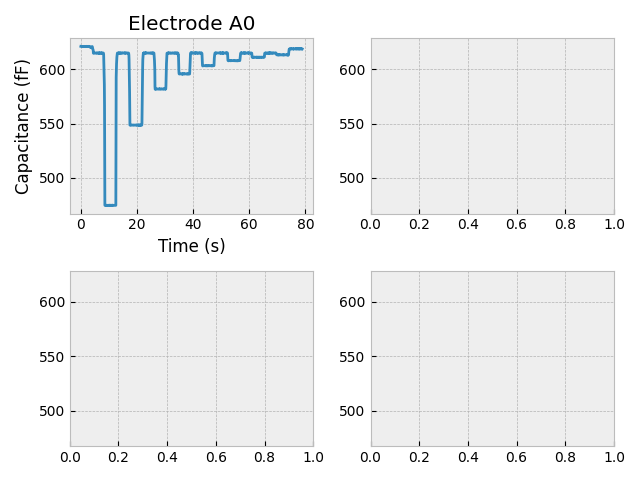

In [19]:
from collections import defaultdict
num_trials = 4
fig, axs = plt.subplots(2, 2)

smallest_y = np.inf
largest_y = -np.inf
std_devs = defaultdict(list)
for trial in [step_trial]:
    # electrode = int(trial.trial_name.split("_")[2][1:])
    electrode = 0
    row = electrode // 2
    col = electrode % 2

    std_devs[electrode].append(np.std(count2ff(trial.cap_counts)))

    axs[row, col].plot(trial.time, count2ff(trial.cap_counts))
    ylims = axs[row, col].get_ylim()
    smallest_y = min(ylims[0], smallest_y)
    largest_y = max(ylims[1], largest_y)
    axs[row, col].set_title(f"Electrode A{electrode}")
    axs[row, col].set_xlabel("Time (s)")
    axs[row, col].set_ylabel("Capacitance (fF)")


for row in axs:
    for ax in row:
        ax.set_ylim([smallest_y, largest_y])
plt.tight_layout()

sigma_ws = []
for key, item in std_devs.items():
    std_dev = np.median(item)
    sigma_ws.append(std_dev)
    print(f"Median Standard Deviation for electrode {key}: {std_dev:.4f}fF")

A couple things to note. We'd expect electrode A3 to have the smallest mutual capacitance. It's possible that the reason it's much higher is because my tape job is not as good (with more exposed wire). Testing with coax wires would help remove that possibility.

It's possible that the standard deviation for electrodes A0 and A2 are affected by the random spikes which appear in the data. These spikes seem to be caused by continuity interruptions from the fact that everything is just taped together.

We'll continue the analysis with the separate standard deviations for the separate electrodes, although the final conclusion should not be taken into consideration due to the measurement issues.

<!-- For this notebook, let's assume that $\sigma_w=0.0315\text{fF}$. -->

Let's now take a look at the capacitance change from introducing the ground plane. 

For each trial, a box plot of the high measurement, $C_{tr}$, and low measurement, $C_{tr} + \Delta C_{tr}$, are depicted. That is, the measurement without the ground plane and the measurement with the ground plane. For each segment between the change points, the median value is taken. The box plot is of these median values. This is to avoid a dependence on the duration of the data collection at a particular point. 

Text(0, 0.5, 'Capacitance [fF]')

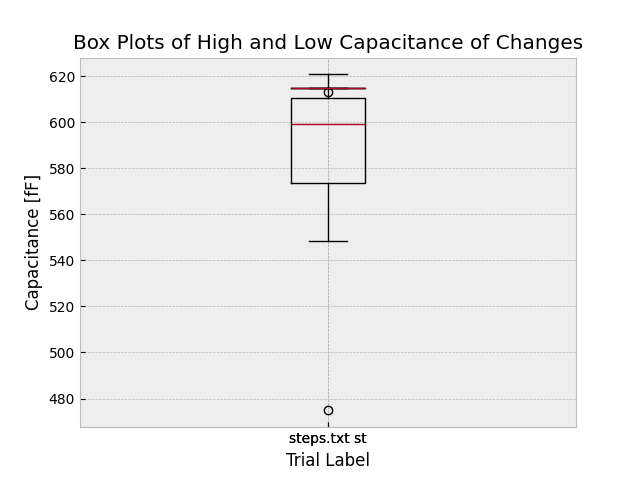

In [20]:
change_padding = 5

fig, ax = plt.subplots()
high_data = []
low_data = []
trial_labels = []

for trial in [step_trial]:
    electrode = trial.trial_name.split("_")[2]
    trial_num = trial.trial_name.split("_")[-1][:2]
    trial_labels.append(f"{electrode} {trial_num}")

    algo = rpt.Pelt(model="rbf").fit(trial.cap_counts)
    change_points = np.array(algo.predict(pen=10))
    region_starts = np.r_[0, change_points[:-1] + change_padding]
    region_ends = change_points - change_padding

    trial_high_data = []
    trial_low_data = []

    for idx, (start, end) in enumerate(zip(region_starts, region_ends)):
        data_slice = count2ff(trial.cap_counts[start:end])
        median = np.median(data_slice)
        if idx % 2 == 0:
            trial_high_data.append(median)
        else:
            trial_low_data.append(median)
    
    high_data.append(np.hstack(trial_high_data))
    low_data.append(np.hstack(trial_low_data))
    
ax.boxplot(high_data, tick_labels=trial_labels)
ax.boxplot(low_data, tick_labels=trial_labels)
ax.set_title("Box Plots of High and Low Capacitance of Changes")
ax.set_xlabel("Trial Label")
ax.set_ylabel("Capacitance [fF]")

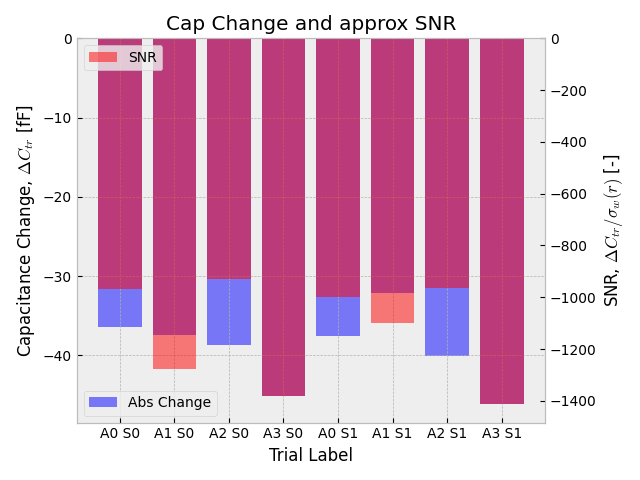

In [41]:
# Data is processed this way because it's ragged because I missed a place/pick :)
high_data = np.array([np.median(trial) for trial in high_data])
low_data = np.array([np.median(trial) for trial in low_data])
cap_change = low_data - high_data

fig, ax = plt.subplots()
ax.bar(trial_labels, cap_change, color="b", alpha=0.5, label="Abs Change")
twinx = ax.twinx()
twinx.bar(trial_labels, cap_change/np.tile(sigma_ws, 2), color="r", alpha = 0.5, label="SNR")
twinx.grid(False)

ax.set_ylabel(r"Capacitance Change, $\Delta C_{tr}$ [fF]")
twinx.set_ylabel(r"SNR, $\Delta C_{tr} / \sigma_w(r)$ [-]")
ax.legend()
twinx.legend(loc=2)

ax.set_title("Cap Change and approx SNR")
ax.set_xlabel("Trial Label")
plt.tight_layout()